In [1]:
%pip install -q ../introdl

    torch (>=1.9.*)
           ~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [1]:
# imports

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from torchinfo import summary
from sklearn.metrics import mean_absolute_error

from introdl.utils import get_device, load_results, load_model
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches


# Early Stopping Demo

We'll use the nonlinear regression problem from Lesson 1 to demonstrate how early stopping works.

In [2]:
# create the "M" curve data

torch.manual_seed(42); # make results reproducible

def MCurve(x):
    """
    The "M" curve function.

    Parameters:
    - x (torch.Tensor): The input values.

    Returns:
    - y (torch.Tensor): The output values.
    """
    return 3 * F.relu(x + 6) - 6 * F.relu(x + 4) + 6 * F.relu(x) - 6 * F.relu(x - 4)  # f(x) is an "M" curve

def makeMCurveData(num_samples, std_dev=0.5):
    """
    Generate synthetic data for the "M" curve.

    Parameters:
    - num_samples (int): The number of data points to generate.
    - std_dev (float): The standard deviation of the noise added to the data.

    Returns:
    - x (torch.Tensor): The input values.
    - y (torch.Tensor): The output values with added noise.
    """
    x = torch.rand(num_samples) * 12 - 6
    y = MCurve(x)
    noise = std_dev * torch.randn(num_samples)  # normally distributed noise
    return x, y + noise

x_train, y_train = makeMCurveData(1000) # roughly the same as in NN Playground
x_valid, y_valid = makeMCurveData(200) 
x_test, y_test = makeMCurveData(1000)

In [3]:
train_dataset = TensorDataset(x_train.reshape(-1,1), 
                              y_train.reshape(-1,1))
valid_dataset = TensorDataset(x_valid.reshape(-1,1), 
                             y_valid.reshape(-1,1))

In [4]:
batch_size = 50 # we set this the same as in Neural Network playground
train_loader = DataLoader(train_dataset, 
                          batch_size = batch_size, 
                          shuffle=True)
valid_loader = DataLoader(valid_dataset, 
                         batch_size = batch_size, 
                         shuffle=False)

In [5]:
class CurveFitter(nn.Module):
    def __init__(self):
        super(CurveFitter, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 8),   # First hidden layer (input: 1, output: 8)
            nn.ReLU(),         # Tanh activation function
            nn.Linear(8, 8),   # Second hidden layer (input: 8, output: 8)
            nn.ReLU(),         # Tanh activation function
            nn.Linear(8, 1)    # Output layer (input: 8, output: 1)
        )

    def forward(self, x):
        return self.model(x)

model = CurveFitter()
model

CurveFitter(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [6]:
# Mean Square Error Loss
loss_func = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.03)

# Mean Absolute Error metric for monitoring
from sklearn.metrics import mean_absolute_error
score_funcs = {'MAE':mean_absolute_error}

# determine device to run the model on
device = get_device() # from course package
print(f"Using device: {device}")

# checkpoint filename for saving model
ckpt_file = 'models/model_M_early.pt'

epochs = 1000

Using device: mps


In [7]:
results = train_network(model,
            loss_func,
            train_loader,
            device=device,
            val_loader=valid_loader,
            epochs = epochs,
            optimizer = optimizer,
            score_funcs = score_funcs,
            checkpoint_file=ckpt_file,
            early_stop_metric = "MAE",
            patience = 100)

Epoch:  24%|██▍       | 239/1000 [00:22<01:12, 10.50it/s]

Early stopping at epoch 239


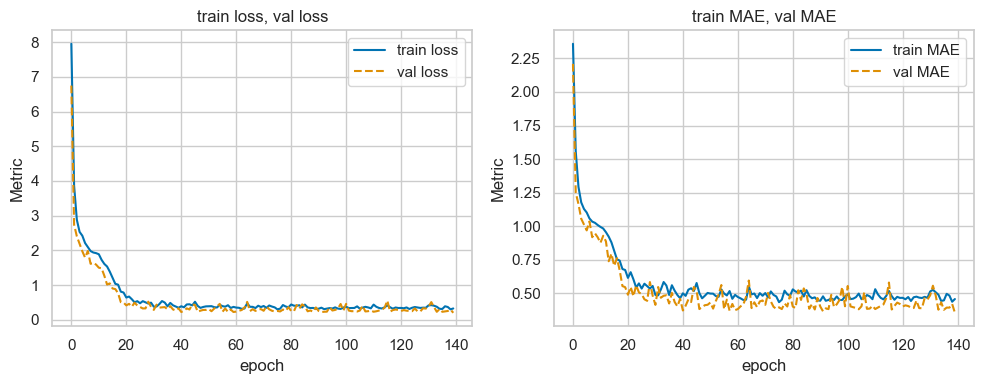

In [8]:
results = load_results('models/model_M_early.pt') # load results from checkpoint and returns data frame

plot_training_metrics(results,[['train loss', 'val loss'],['train MAE', 'val MAE']])

#### Visualize the fit

We can already see from the mean absolute error on the test data that our trained model is doing a good job, but for this curve-fitting problem it's relatively easy to visualize how well the trained network fits the data.  First we'll create a new instance of the model and overwrite its randomly initialized parameter values with the saved parameters from our checkpoint file.

In [9]:
# you can either pass in the model instance or the class
model = load_model(CurveFitter, 'models/model_M_early.pt')


Now we evaluate the model on a sequence of equally spaced inputs for visualization.  We'll discuss the code below in the next section, when we discuss using a model to make predictions for new data, but here's the plot.

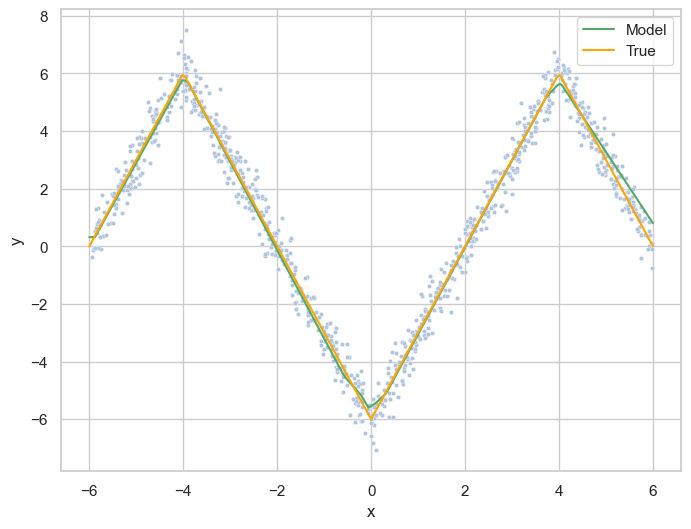

In [10]:
x = torch.linspace(-6,6,201).reshape(-1,1) # add a batch dimension
model.to(torch.device('cpu')) # move model to CPU if necessary
with torch.no_grad():
    y = model(x)
y_true = MCurve(x)

# Add the scatter plot for noisy y-values
sns.scatterplot(x=x_test, y=y_test, s=10, color = "lightsteelblue") # blue
sns.lineplot(x=x.squeeze(),y=y.squeeze(),color="#55A868",label="Model") # green
sns.lineplot(x=x.squeeze(),y=y_true.squeeze(),color="orange",label="True") # orange

plt.xlabel('x')
plt.ylabel('y');
